In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import mannwhitneyu
import re
import os
import seaborn as sns
from matplotlib import cm, colors

In [2]:
PATH = os.getcwd()
TEST_FOLDER = 'test-result'
REGGRESSION_FOLDER = 'regressions'
PARAMETRIC_FOLDER = 'parametric'
ACENTUACION_FOLDER = 'Acentuacion'
CADENCIA_FOLDER = 'Cadencia'
INTELIGIBILIDAD_FOLDER = 'Inteligibilidad'
NATURALIDAD_FOLDER = 'Naturalidad'
PRONUNCIACION_FOLDER = 'Pronunciacion'
MALE_FOLDER = 'masculino'
FEMALE_FOLDER = 'femenino'

In [3]:
# Diccionario para guardar los p-value
dicc_p_value = {
    'subjetive_parameter':[],
    'ZCR':[],
    'RMS':[],
    'f0':[],
    'genero':[] 
}

In [4]:
# Voy a limpiar los graficos que hay en las carpetas

list_files = os.listdir(os.path.join(PATH, TEST_FOLDER, REGGRESSION_FOLDER, PARAMETRIC_FOLDER))

list_folder = []
for folder in list_files:
    if not folder.endswith('.xlsx'):
        list_folder.append(folder)
        
SUBFOLDER_GENDER = ['masculino', 'femenino']

for folder in list_folder:
    for gender in SUBFOLDER_GENDER:
        os.chdir(os.path.join(os.path.join(PATH, TEST_FOLDER, REGGRESSION_FOLDER, PARAMETRIC_FOLDER, folder, gender)))
        all_files = os.listdir()
        if len(all_files) == 0:
            continue
        for f in all_files:
            os.remove(f)

os.chdir(PATH)

In [5]:
list_folder

['Acentuacion', 'Cadencia', 'Inteligibilidad', 'Naturalidad', 'Pronunciacion']

In [6]:
merged_df = pd.read_csv(r'aux_file\data_regression.csv')

In [7]:
obj_params = pd.read_excel('voces_test_rms.ods')

In [8]:
obj_params.head()

,zero_crossing_rate,rms,mfcc,pitch,genero,file
0,0.075944,-27.5,[-4.0729132e+02 1.3076346e+02 -3.0420111e+01 ...,111.111716,femenino,hyacinthe-lovo-v3.wav
1,0.093035,-27.0,[-424.61664 138.61742 -14.495688 3...,101.312090,femenino,lola-murf.wav
2,0.093043,-22.5,[-3.71418152e+02 1.31561859e+02 -1.60284328e+...,76.492752,masculino,neural2B-GCP.wav
3,0.098051,-22.0,[-3.4943588e+02 1.2940279e+02 -1.8956478e+01 ...,68.726911,masculino,alonso-naturalreader.wav
4,0.105458,-21.5,[-3.5115176e+02 1.1943483e+02 -1.9279911e+01 ...,69.045778,masculino,antonio-murf.wav


In [9]:
df_union = pd.merge(
    merged_df,
    obj_params,
    how='left',
    left_on='filename',
    right_on='file'
).drop(columns=['file'])

In [10]:
df_union.rename(
    columns={
        'zero_crossing_rate': 'zcr',
        'pitch': 'f0'
    },
    inplace=True
)

In [11]:
df_union.head()

,ID,filename,Inteligibilidad,Pronunciacion,Acentuacion,Naturalidad,Cadencia,zcr,rms,mfcc,f0,genero
0,1,alonso-naturalreader.wav,4.897959,4.645833,4.469388,3.000000,3.836735,0.098051,-22.0,[-3.4943588e+02 1.2940279e+02 -1.8956478e+01 ...,68.726911,masculino
1,2,hyacinthe-lovo-v3.wav,4.979592,4.680851,4.551020,4.183673,4.224490,0.075944,-27.5,[-4.0729132e+02 1.3076346e+02 -3.0420111e+01 ...,111.111716,femenino
2,3,neural2C-pitchmodified-speedmodified.wav,4.346939,3.926829,2.816327,1.775510,1.653061,0.251626,-25.0,[-4.4141333e+02 8.9362648e+01 -1.2164741e+01 ...,98.468505,masculino
3,4,francisca-lovo-v2.wav,4.693878,4.304348,4.244898,2.979592,3.755102,0.137822,-26.1,[-454.8679 72.41395 -14.8625145 45.9...,116.353345,femenino
4,5,antoni-evenlabs-linguistico-v2.wav,4.571429,4.113636,3.183673,1.836735,1.591837,0.239188,-24.0,[-406.19888 84.30505 -12.89493 18.8...,78.968152,masculino


## SelectorFeature

In [12]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from mlxtend.feature_selection import SequentialFeatureSelector
from sklearn.utils import check_random_state
from sklearn.model_selection import permutation_test_score
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

### Inteligibilidad

In [13]:
df_inteligibilidad = df_union.loc[:, ['Inteligibilidad', 'zcr', 'rms', 'f0', 'genero']]

#### Masculino

In [14]:
# Lista de p-values
p_values = []

mask_gender = df_inteligibilidad.genero == 'masculino'

df_inteligibilidad_male = df_inteligibilidad[mask_gender].drop(columns=['genero'])

In [15]:
# Cargamos los datos
X = np.array(df_inteligibilidad_male.drop(columns=['Inteligibilidad'])) # df_objetivos es el DataFrame con los parámetros objetivos
y = np.array(df_inteligibilidad_male.Inteligibilidad) # df_subjetivos es el DataFrame con los parámetros subjetivos

# Creamos el modelo de regresión lineal
regr_multivar = LinearRegression()

# Creamos el selector de características hacia adelante
forward_selector = SequentialFeatureSelector(regr_multivar, k_features='best', forward=True, scoring='neg_mean_squared_error')

# Entrenamos el selector de características
forward_selector.fit(X, y)

# Obtenemos las características seleccionadas
selected_features = forward_selector.k_feature_idx_

# Imprimimos las características seleccionadas
print('Características seleccionadas:', selected_features)

# Agregamos una columna de unos para representar el término de intercepción
X2 = sm.add_constant(X)

# Creamos el modelo OLS (mínimos cuadrados ordinarios) y lo ajustamos a los datos
model = sm.OLS(y, X2)
results = model.fit()

# Imprimimos los p-valores para cada característica seleccionada
for feature, pvalue in zip(list(range(X.shape[1])), results.pvalues[1:]):

    if feature == 0:
        feature = 'ZCR'
    elif feature == 1:
        feature = 'RMS'
    else:
        feature = 'f0'
    
    print(f'Característica {feature}: p-valor = {pvalue:.4f}')

    p_values.append(pvalue)
    dicc_p_value[feature].append(pvalue)

dicc_p_value['subjetive_parameter'].append('Inteligibilidad')
dicc_p_value['genero'].append('masculino')


Características seleccionadas: (0,)
Característica ZCR: p-valor = 0.0807
Característica RMS: p-valor = 0.2724
Característica f0: p-valor = 0.3885


In [16]:
# Dicc auxiliar con los nombres asociadas a las variables
dicc_names_features = {
    'zcr_model': 0,
    'rms_model': 1,
    'f0_model': 2
}

# Dicc de los modelos
dicc_model = {}

# Dicc de las predicciones
dicc_pred = {}

for selected_feature in selected_features:
    # Entrenamos el modelo de regresión con las características seleccionadas
    regr_multivar = LinearRegression()
    regr_multivar.fit(X[:, selected_feature].reshape(-1, 1), y.ravel())

    # Almacenamos en dicc_model la clave asociada al modelo que se entrenó y el objeto modelo
    for key, value in dicc_names_features.items():
        if value == selected_feature:
            dicc_model[key] = regr_multivar

    # Obtenemos las predicciones del modelo para las características seleccionadas
    y_pred = regr_multivar.predict(X[:, selected_feature].reshape(-1, 1))

    # Almacenamos en dicc_pred la clave asociada al modelo que se entrenó y la predicción
    for key, value in dicc_names_features.items():
        if value == selected_feature:
            dicc_pred[key] = y_pred


In [17]:
list_equ = []

for key, model in dicc_model.items():
    # Obtenemos los valores de w y b
    w = model.coef_[0]
    b = model.intercept_
    
    label = key.replace("_model", "")
    if label == 'f0':
        label = r'$f_{0}$'
    else:
        label = label.upper()

    # Construimos la cadena de texto para la ecuación del hiperplano y su p-valor
    equation = f'y = {w:.2f} * {label} + {b:.2f} - p-valor = {p_values[dicc_names_features[key]]:.3f}'

    # Agregamos la cadena a la lista
    list_equ.append(equation)

# Mostramos el resultado
for equ in list_equ:
    print(equ)


y = -3.07 * ZCR + 5.13 - p-valor = 0.081


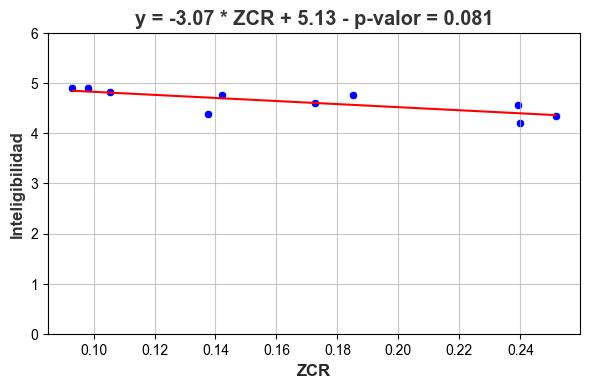

In [18]:
dims = (6 * len(dicc_model), 4)
fig, ax = plt.subplots(figsize=dims, ncols=len(dicc_model))

with sns.axes_style('darkgrid'):
    for i, (key, model) in enumerate(dicc_model.items()):
        if isinstance(ax, np.ndarray):
            ax_i = ax[i]
        else:
            ax_i = ax
        label = key.replace("_model", "")
        if label == 'f0':
            label = r'$f_{0}$'
        else:
            label = label.upper()
        g = sns.scatterplot(x=X[:, dicc_names_features[key]], y=y, ax=ax_i, color='blue')
        g = sns.lineplot(x=X[:, dicc_names_features[key]], y=dicc_pred[key], ax=ax_i, color='red')
        g.text(0.5, -0.1, label, weight='bold', size='large', family='Arial', stretch='extra-expanded', ha='center', va='top', transform=g.transAxes)
        g.set_ylabel('Inteligibilidad', weight='bold', size='large', alpha=0.8, family='Arial', stretch='extra-expanded')
        g.set_title(list_equ[i], weight='bold', size='x-large', alpha=0.8, family='Arial', stretch='extra-expanded')
        g.grid(alpha=0.7)
        ax_i.set_ylim(0, 6)

    plt.tight_layout()
    plt.savefig(os.path.join(PATH, TEST_FOLDER, REGGRESSION_FOLDER, PARAMETRIC_FOLDER, INTELIGIBILIDAD_FOLDER, MALE_FOLDER, 'regresiones_inteligibilidad_male.png'))
    plt.show()


In [19]:
if len(dicc_model) == 2:
    import plotly.express as px
    import plotly.graph_objects as go

    # Seleccionamos solo las características seleccionadas en X
    X_selected = X[:, selected_features]

    # Entrenamos el modelo de regresión con las características seleccionadas
    regr_multivar = LinearRegression()
    regr_multivar.fit(X_selected, y)

    # Obtenemos las predicciones del modelo para las características seleccionadas
    y_pred = regr_multivar.predict(X_selected)

    # Crear la figura
    fig = px.scatter_3d(x=X_selected[:, 0], y=X_selected[:, 1], z=y)

    # Crear el plano de regresión
    xx, yy = np.meshgrid(X_selected[:, 0], X_selected[:, 1])
    zz = regr_multivar.intercept_ + np.dot(np.array([xx.ravel(), yy.ravel()]).T, regr_multivar.coef_.ravel()).reshape(xx.shape)
    fig.add_trace(go.Surface(x=xx, y=yy, z=zz, opacity=0.5))

    # Construir la cadena de texto para la ecuación del plano
    equation = f'z = {regr_multivar.intercept_.round(2)}'
    for i, (key, model) in enumerate(dicc_model.items()):
        equation += f' + {regr_multivar.coef_[i].round(2)} * {key.replace("_model", "")}'
    
    # Centrar el título
    fig.update_layout(title=dict(text=equation, x=0.5, xanchor='center'))

    # Etiquetas de los ejes y rango del eje z
    fig.update_layout(scene=dict(xaxis_title=list(dicc_model.keys())[0].replace("_model", ""), yaxis_title=list(dicc_model.keys())[1].replace("_model", ""), zaxis_title='Inteligibilidad', zaxis=dict(range=[0, 6]), yaxis=dict(tickvals=[-28, -26, -24, -22])))

    fig.write_html(
       os.path.join(PATH, TEST_FOLDER, REGGRESSION_FOLDER, PARAMETRIC_FOLDER, INTELIGIBILIDAD_FOLDER, MALE_FOLDER, 'regresion_inteligibilidad_multivariable_male.html')
    )

    fig.show()


#### Femenino

In [20]:
# Lista de p-values
p_values = []

mask_gender = df_inteligibilidad.genero == 'femenino'

df_inteligibilidad_female = df_inteligibilidad[mask_gender].drop(columns=['genero'])

In [21]:
# Cargamos los datos
X = np.array(df_inteligibilidad_female.drop(columns=['Inteligibilidad'])) # df_objetivos es el DataFrame con los parámetros objetivos
y = np.array(df_inteligibilidad_female.Inteligibilidad) # df_subjetivos es el DataFrame con los parámetros subjetivos

# Creamos el modelo de regresión lineal
regr_multivar = LinearRegression()

# Creamos el selector de características hacia adelante
forward_selector = SequentialFeatureSelector(regr_multivar, k_features='best', forward=True, scoring='neg_mean_squared_error')

# Entrenamos el selector de características
forward_selector.fit(X, y)

# Obtenemos las características seleccionadas
selected_features = forward_selector.k_feature_idx_

# Imprimimos las características seleccionadas
print('Características seleccionadas:', selected_features)

# Agregamos una columna de unos para representar el término de intercepción
X2 = sm.add_constant(X)

# Creamos el modelo OLS (mínimos cuadrados ordinarios) y lo ajustamos a los datos
model = sm.OLS(y, X2)
results = model.fit()

# Imprimimos los p-valores para cada característica seleccionada
for feature, pvalue in zip(list(range(X.shape[1])), results.pvalues[1:]):

    if feature == 0:
        feature = 'ZCR'
    elif feature == 1:
        feature = 'RMS'
    else:
        feature = 'f0'
    
    print(f'Característica {feature}: p-valor = {pvalue:.4f}')

    p_values.append(pvalue)
    dicc_p_value[feature].append(pvalue)

dicc_p_value['subjetive_parameter'].append('Inteligibilidad')
dicc_p_value['genero'].append('femenino')


Características seleccionadas: (0, 2)
Característica ZCR: p-valor = 0.0155
Característica RMS: p-valor = 0.8422
Característica f0: p-valor = 0.0255


In [22]:
# Dicc auxiliar con los nombres asociadas a las variables
dicc_names_features = {
    'zcr_model': 0,
    'rms_model': 1,
    'f0_model': 2
}

# Dicc de los modelos
dicc_model = {}

# Dicc de las predicciones
dicc_pred = {}

for selected_feature in selected_features:
    # Entrenamos el modelo de regresión con las características seleccionadas
    regr_multivar = LinearRegression()
    regr_multivar.fit(X[:, selected_feature].reshape(-1, 1), y.ravel())

    # Almacenamos en dicc_model la clave asociada al modelo que se entrenó y el objeto modelo
    for key, value in dicc_names_features.items():
        if value == selected_feature:
            dicc_model[key] = regr_multivar

    # Obtenemos las predicciones del modelo para las características seleccionadas
    y_pred = regr_multivar.predict(X[:, selected_feature].reshape(-1, 1))

    # Almacenamos en dicc_pred la clave asociada al modelo que se entrenó y la predicción
    for key, value in dicc_names_features.items():
        if value == selected_feature:
            dicc_pred[key] = y_pred


In [23]:
list_equ = []

for key, model in dicc_model.items():
    # Obtenemos los valores de w y b
    w = model.coef_[0]
    b = model.intercept_
    
    label = key.replace("_model", "")
    if label == 'f0':
        label = r'$f_{0}$'
    else:
        label = label.upper()

    # Construimos la cadena de texto para la ecuación del hiperplano y su p-valor
    equation = f'y = {w:.2f} * {label} + {b:.2f} - p-valor = {p_values[dicc_names_features[key]]:.3f}'

    # Agregamos la cadena a la lista
    list_equ.append(equation)

# Mostramos el resultado
for equ in list_equ:
    print(equ)


y = -2.65 * ZCR + 5.15 - p-valor = 0.015
y = -0.01 * $f_{0}$ + 5.49 - p-valor = 0.026


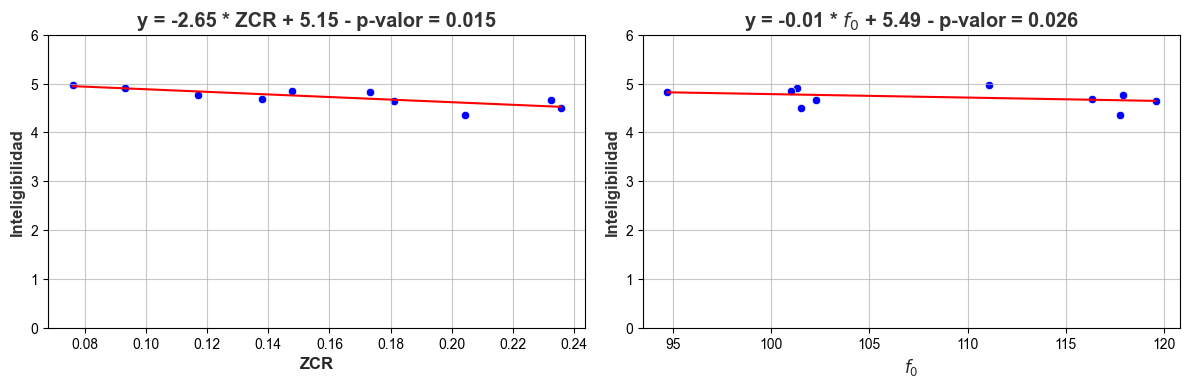

In [24]:
dims = (6 * len(dicc_model), 4)
fig, ax = plt.subplots(figsize=dims, ncols=len(dicc_model))

with sns.axes_style('darkgrid'):
    for i, (key, model) in enumerate(dicc_model.items()):
        if isinstance(ax, np.ndarray):
            ax_i = ax[i]
        else:
            ax_i = ax
        label = key.replace("_model", "")
        if label == 'f0':
            label = r'$f_{0}$'
        else:
            label = label.upper()
        g = sns.scatterplot(x=X[:, dicc_names_features[key]], y=y, ax=ax_i, color='blue')
        g = sns.lineplot(x=X[:, dicc_names_features[key]], y=dicc_pred[key], ax=ax_i, color='red')
        g.text(0.5, -0.1, label, weight='bold', size='large', family='Arial', stretch='extra-expanded', ha='center', va='top', transform=g.transAxes)
        g.set_ylabel('Inteligibilidad', weight='bold', size='large', alpha=0.8, family='Arial', stretch='extra-expanded')
        g.set_title(list_equ[i], weight='bold', size='x-large', alpha=0.8, family='Arial', stretch='extra-expanded')
        g.grid(alpha=0.7)
        ax_i.set_ylim(0, 6)

    plt.tight_layout()
    plt.savefig(
        os.path.join(PATH, TEST_FOLDER, REGGRESSION_FOLDER, PARAMETRIC_FOLDER, INTELIGIBILIDAD_FOLDER, FEMALE_FOLDER, 'regresiones_inteligibilidad_female.png')
    )
    plt.show()


In [26]:
if len(dicc_model) == 2:
    import plotly.express as px
    import plotly.graph_objects as go

    # Seleccionamos solo las características seleccionadas en X
    X_selected = X[:, selected_features]

    # Entrenamos el modelo de regresión con las características seleccionadas
    regr_multivar = LinearRegression()
    regr_multivar.fit(X_selected, y)

    # Obtenemos las predicciones del modelo para las características seleccionadas
    y_pred = regr_multivar.predict(X_selected)

    # Crear la figura
    fig = px.scatter_3d(x=X_selected[:, 0], y=X_selected[:, 1], z=y)

    # Crear el plano de regresión
    xx, yy = np.meshgrid(X_selected[:, 0], X_selected[:, 1])
    zz = regr_multivar.intercept_ + np.dot(np.array([xx.ravel(), yy.ravel()]).T, regr_multivar.coef_.ravel()).reshape(xx.shape)
    fig.add_trace(go.Surface(x=xx, y=yy, z=zz, opacity=0.5))

    # Construir la cadena de texto para la ecuación del plano
    equation = f'z = {regr_multivar.intercept_.round(2)}'
    for i, (key, model) in enumerate(dicc_model.items()):
        equation += f' + {regr_multivar.coef_[i].round(2)} * {key.replace("_model", "")}'
    
    # Centrar el título
    fig.update_layout(title=dict(text=equation, x=0.5, xanchor='center'))

    # Etiquetas de los ejes y rango del eje z
    fig.update_layout(scene=dict(xaxis_title=list(dicc_model.keys())[0].replace("_model", ""), yaxis_title=list(dicc_model.keys())[1].replace("_model", ""), zaxis_title='Inteligibilidad', zaxis=dict(range=[0, 6]), yaxis=dict(tickvals=[100, 105, 110, 115])))

    fig.write_html(
       os.path.join(PATH, TEST_FOLDER, REGGRESSION_FOLDER, PARAMETRIC_FOLDER, INTELIGIBILIDAD_FOLDER, FEMALE_FOLDER, 'regresion_inteligibilidad_multivariable_female.html')
    )

    fig.show()


### Pronunciacion

In [27]:
df_pronunciacion = df_union.loc[:, ['Pronunciacion', 'zcr', 'rms', 'f0', 'genero']]

#### Masculino

In [28]:
# Lista de p-values
p_values = []

mask_gender = df_pronunciacion.genero == 'masculino'

df_pronunciacion_male = df_pronunciacion[mask_gender].drop(columns=['genero'])

In [29]:
# Cargamos los datos
X = np.array(df_pronunciacion_male.drop(columns=['Pronunciacion'])) # df_objetivos es el DataFrame con los parámetros objetivos
y = np.array(df_pronunciacion_male.Pronunciacion) # df_subjetivos es el DataFrame con los parámetros subjetivos

# Creamos el modelo de regresión lineal
regr_multivar = LinearRegression()

# Creamos el selector de características hacia adelante
forward_selector = SequentialFeatureSelector(regr_multivar, k_features='best', forward=True, scoring='neg_mean_squared_error')

# Entrenamos el selector de características
forward_selector.fit(X, y)

# Obtenemos las características seleccionadas
selected_features = forward_selector.k_feature_idx_

# Imprimimos las características seleccionadas
print('Características seleccionadas:', selected_features)

# Agregamos una columna de unos para representar el término de intercepción
X2 = sm.add_constant(X)

# Creamos el modelo OLS (mínimos cuadrados ordinarios) y lo ajustamos a los datos
model = sm.OLS(y, X2)
results = model.fit()

# Imprimimos los p-valores para cada característica seleccionada
for feature, pvalue in zip(list(range(X.shape[1])), results.pvalues[1:]):

    if feature == 0:
        feature = 'ZCR'
    elif feature == 1:
        feature = 'RMS'
    else:
        feature = 'f0'
    
    print(f'Característica {feature}: p-valor = {pvalue:.4f}')

    p_values.append(pvalue)
    dicc_p_value[feature].append(pvalue)

dicc_p_value['subjetive_parameter'].append('Pronunciación')
dicc_p_value['genero'].append('masculino')


Características seleccionadas: (0, 1)
Característica ZCR: p-valor = 0.0027
Característica RMS: p-valor = 0.0152
Característica f0: p-valor = 0.1713


In [30]:
# Dicc auxiliar con los nombres asociadas a las variables
dicc_names_features = {
    'zcr_model': 0,
    'rms_model': 1,
    'f0_model': 2
}

# Dicc de los modelos
dicc_model = {}

# Dicc de las predicciones
dicc_pred = {}

for selected_feature in selected_features:
    # Entrenamos el modelo de regresión con las características seleccionadas
    regr_multivar = LinearRegression()
    regr_multivar.fit(X[:, selected_feature].reshape(-1, 1), y.ravel())

    # Almacenamos en dicc_model la clave asociada al modelo que se entrenó y el objeto modelo
    for key, value in dicc_names_features.items():
        if value == selected_feature:
            dicc_model[key] = regr_multivar

    # Obtenemos las predicciones del modelo para las características seleccionadas
    y_pred = regr_multivar.predict(X[:, selected_feature].reshape(-1, 1))

    # Almacenamos en dicc_pred la clave asociada al modelo que se entrenó y la predicción
    for key, value in dicc_names_features.items():
        if value == selected_feature:
            dicc_pred[key] = y_pred


In [31]:
list_equ = []

for key, model in dicc_model.items():
    # Obtenemos los valores de w y b
    w = model.coef_[0]
    b = model.intercept_
    
    label = key.replace("_model", "")
    if label == 'f0':
        label = r'$f_{0}$'
    else:
        label = label.upper()

    # Construimos la cadena de texto para la ecuación del hiperplano y su p-valor
    equation = f'y = {w:.2f} * {label} + {b:.2f} - p-valor = {p_values[dicc_names_features[key]]:.3f}'

    # Agregamos la cadena a la lista
    list_equ.append(equation)

# Mostramos el resultado
for equ in list_equ:
    print(equ)


y = -3.27 * ZCR + 4.90 - p-valor = 0.003
y = 0.06 * RMS + 5.79 - p-valor = 0.015


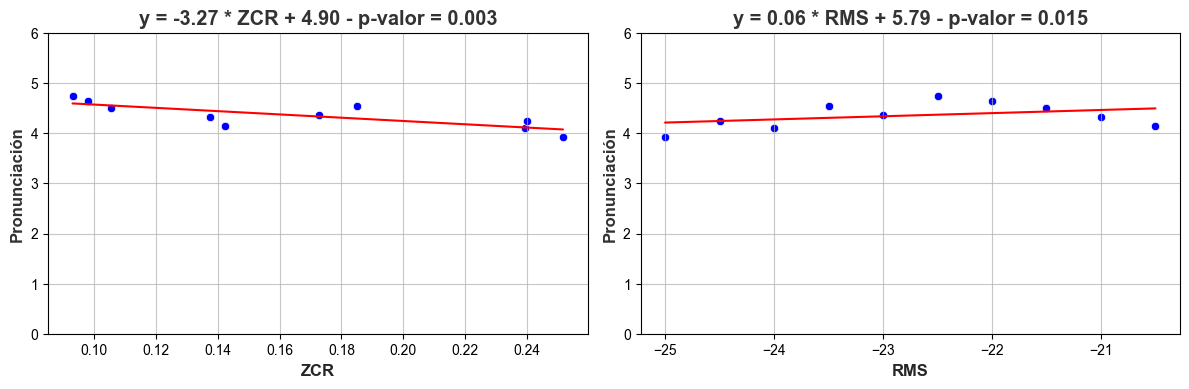

In [32]:
dims = (6 * len(dicc_model), 4)
fig, ax = plt.subplots(figsize=dims, ncols=len(dicc_model))

with sns.axes_style('darkgrid'):
    for i, (key, model) in enumerate(dicc_model.items()):
        if isinstance(ax, np.ndarray):
            ax_i = ax[i]
        else:
            ax_i = ax
        label = key.replace("_model", "")
        if label == 'f0':
            label = r'$f_{0}$'
        else:
            label = label.upper()
        g = sns.scatterplot(x=X[:, dicc_names_features[key]], y=y, ax=ax_i, color='blue')
        g = sns.lineplot(x=X[:, dicc_names_features[key]], y=dicc_pred[key], ax=ax_i, color='red')
        g.text(0.5, -0.1, label, weight='bold', size='large', family='Arial', stretch='extra-expanded', ha='center', va='top', transform=g.transAxes)
        g.set_ylabel('Pronunciación', weight='bold', size='large', alpha=0.8, family='Arial', stretch='extra-expanded')
        g.set_title(list_equ[i], weight='bold', size='x-large', alpha=0.8, family='Arial', stretch='extra-expanded')
        g.grid(alpha=0.7)
        ax_i.set_ylim(0, 6)

    plt.tight_layout()
    plt.savefig(os.path.join(PATH, TEST_FOLDER, REGGRESSION_FOLDER, PARAMETRIC_FOLDER, PRONUNCIACION_FOLDER, MALE_FOLDER, 'regresiones_pronunciacion_male.png'))
    plt.show()


In [34]:
if len(dicc_model) == 2:
    import plotly.express as px
    import plotly.graph_objects as go

    # Seleccionamos solo las características seleccionadas en X
    X_selected = X[:, selected_features]

    # Entrenamos el modelo de regresión con las características seleccionadas
    regr_multivar = LinearRegression()
    regr_multivar.fit(X_selected, y)

    # Obtenemos las predicciones del modelo para las características seleccionadas
    y_pred = regr_multivar.predict(X_selected)

    # Crear la figura
    fig = px.scatter_3d(x=X_selected[:, 0], y=X_selected[:, 1], z=y)

    # Crear el plano de regresión
    xx, yy = np.meshgrid(X_selected[:, 0], X_selected[:, 1])
    zz = regr_multivar.intercept_ + np.dot(np.array([xx.ravel(), yy.ravel()]).T, regr_multivar.coef_.ravel()).reshape(xx.shape)
    fig.add_trace(go.Surface(x=xx, y=yy, z=zz, opacity=0.5))

    # Construir la cadena de texto para la ecuación del plano
    equation = f'z = {regr_multivar.intercept_.round(2)}'
    for i, (key, model) in enumerate(dicc_model.items()):
        equation += f' + {regr_multivar.coef_[i].round(2)} * {key.replace("_model", "")}'
    
    # Centrar el título
    fig.update_layout(title=dict(text=equation, x=0.5, xanchor='center'))

    # Etiquetas de los ejes y rango del eje z
    fig.update_layout(scene=dict(xaxis_title=list(dicc_model.keys())[0].replace("_model", ""), yaxis_title=list(dicc_model.keys())[1].replace("_model", ""), zaxis_title='Pronunciación', zaxis=dict(range=[0, 6]), yaxis=dict(tickvals=[-24, -23, -22, -21])))

    fig.write_html(
       os.path.join(PATH, TEST_FOLDER, REGGRESSION_FOLDER, PARAMETRIC_FOLDER, PRONUNCIACION_FOLDER, MALE_FOLDER, 'regresion_pronunciacion_multivariable_male.html')
    )

    fig.show()


#### Femenino

In [35]:
# Lista de p-values
p_values = []

mask_gender = df_pronunciacion.genero == 'femenino'

df_pronunciacion_female = df_pronunciacion[mask_gender].drop(columns=['genero'])

In [36]:
# Cargamos los datos
X = np.array(df_pronunciacion_female.drop(columns=['Pronunciacion'])) # df_objetivos es el DataFrame con los parámetros objetivos
y = np.array(df_pronunciacion_female.Pronunciacion) # df_subjetivos es el DataFrame con los parámetros subjetivos

# Creamos el modelo de regresión lineal
regr_multivar = LinearRegression()

# Creamos el selector de características hacia adelante
forward_selector = SequentialFeatureSelector(regr_multivar, k_features='best', forward=True, scoring='neg_mean_squared_error')

# Entrenamos el selector de características
forward_selector.fit(X, y)

# Obtenemos las características seleccionadas
selected_features = forward_selector.k_feature_idx_

# Imprimimos las características seleccionadas
print('Características seleccionadas:', selected_features)

# Agregamos una columna de unos para representar el término de intercepción
X2 = sm.add_constant(X)

# Creamos el modelo OLS (mínimos cuadrados ordinarios) y lo ajustamos a los datos
model = sm.OLS(y, X2)
results = model.fit()

# Imprimimos los p-valores para cada característica seleccionada
for feature, pvalue in zip(list(range(X.shape[1])), results.pvalues[1:]):

    if feature == 0:
        feature = 'ZCR'
    elif feature == 1:
        feature = 'RMS'
    else:
        feature = 'f0'
    
    print(f'Característica {feature}: p-valor = {pvalue:.4f}')

    p_values.append(pvalue)
    dicc_p_value[feature].append(pvalue)

dicc_p_value['subjetive_parameter'].append('Pronunciación')
dicc_p_value['genero'].append('femenino')


Características seleccionadas: (0, 2)
Característica ZCR: p-valor = 0.1504
Característica RMS: p-valor = 0.6898
Característica f0: p-valor = 0.1047


In [37]:
# Dicc auxiliar con los nombres asociadas a las variables
dicc_names_features = {
    'zcr_model': 0,
    'rms_model': 1,
    'f0_model': 2
}

# Dicc de los modelos
dicc_model = {}

# Dicc de las predicciones
dicc_pred = {}

for selected_feature in selected_features:
    # Entrenamos el modelo de regresión con las características seleccionadas
    regr_multivar = LinearRegression()
    regr_multivar.fit(X[:, selected_feature].reshape(-1, 1), y.ravel())

    # Almacenamos en dicc_model la clave asociada al modelo que se entrenó y el objeto modelo
    for key, value in dicc_names_features.items():
        if value == selected_feature:
            dicc_model[key] = regr_multivar

    # Obtenemos las predicciones del modelo para las características seleccionadas
    y_pred = regr_multivar.predict(X[:, selected_feature].reshape(-1, 1))

    # Almacenamos en dicc_pred la clave asociada al modelo que se entrenó y la predicción
    for key, value in dicc_names_features.items():
        if value == selected_feature:
            dicc_pred[key] = y_pred


In [38]:
list_equ = []

for key, model in dicc_model.items():
    # Obtenemos los valores de w y b
    w = model.coef_[0]
    b = model.intercept_
    
    label = key.replace("_model", "")
    if label == 'f0':
        label = r'$f_{0}$'
    else:
        label = label.upper()

    # Construimos la cadena de texto para la ecuación del hiperplano y su p-valor
    equation = f'y = {w:.2f} * {label} + {b:.2f} - p-valor = {p_values[dicc_names_features[key]]:.3f}'

    # Agregamos la cadena a la lista
    list_equ.append(equation)

# Mostramos el resultado
for equ in list_equ:
    print(equ)


y = -2.48 * ZCR + 4.81 - p-valor = 0.150
y = -0.01 * $f_{0}$ + 5.30 - p-valor = 0.105


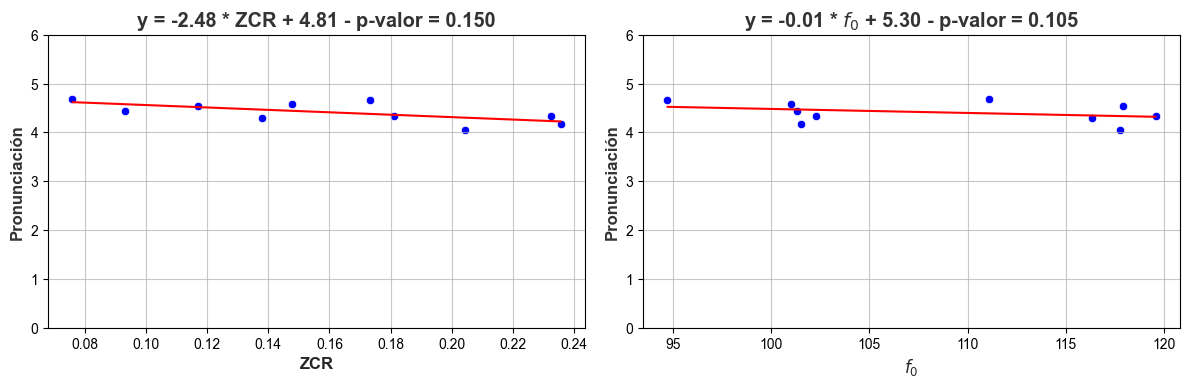

In [39]:
dims = (6 * len(dicc_model), 4)
fig, ax = plt.subplots(figsize=dims, ncols=len(dicc_model))

with sns.axes_style('darkgrid'):
    for i, (key, model) in enumerate(dicc_model.items()):
        if isinstance(ax, np.ndarray):
            ax_i = ax[i]
        else:
            ax_i = ax
        label = key.replace("_model", "")
        if label == 'f0':
            label = r'$f_{0}$'
        else:
            label = label.upper()
        g = sns.scatterplot(x=X[:, dicc_names_features[key]], y=y, ax=ax_i, color='blue')
        g = sns.lineplot(x=X[:, dicc_names_features[key]], y=dicc_pred[key], ax=ax_i, color='red')
        g.text(0.5, -0.1, label, weight='bold', size='large', family='Arial', stretch='extra-expanded', ha='center', va='top', transform=g.transAxes)
        g.set_ylabel('Pronunciación', weight='bold', size='large', alpha=0.8, family='Arial', stretch='extra-expanded')
        g.set_title(list_equ[i], weight='bold', size='x-large', alpha=0.8, family='Arial', stretch='extra-expanded')
        g.grid(alpha=0.7)
        ax_i.set_ylim(0, 6)

    plt.tight_layout()
    plt.savefig(os.path.join(PATH, TEST_FOLDER, REGGRESSION_FOLDER, PARAMETRIC_FOLDER, PRONUNCIACION_FOLDER, FEMALE_FOLDER, 'regresiones_pronunciacion_female.png'))
    plt.show()


In [40]:
if len(dicc_model) == 2:
    import plotly.express as px
    import plotly.graph_objects as go

    # Seleccionamos solo las características seleccionadas en X
    X_selected = X[:, selected_features]

    # Entrenamos el modelo de regresión con las características seleccionadas
    regr_multivar = LinearRegression()
    regr_multivar.fit(X_selected, y)

    # Obtenemos las predicciones del modelo para las características seleccionadas
    y_pred = regr_multivar.predict(X_selected)

    # Crear la figura
    fig = px.scatter_3d(x=X_selected[:, 0], y=X_selected[:, 1], z=y)

    # Crear el plano de regresión
    xx, yy = np.meshgrid(X_selected[:, 0], X_selected[:, 1])
    zz = regr_multivar.intercept_ + np.dot(np.array([xx.ravel(), yy.ravel()]).T, regr_multivar.coef_.ravel()).reshape(xx.shape)
    fig.add_trace(go.Surface(x=xx, y=yy, z=zz, opacity=0.5))

    # Construir la cadena de texto para la ecuación del plano
    equation = f'z = {regr_multivar.intercept_.round(2)}'
    for i, (key, model) in enumerate(dicc_model.items()):
        equation += f' + {regr_multivar.coef_[i].round(2)} * {key.replace("_model", "")}'
    
    # Centrar el título
    fig.update_layout(title=dict(text=equation, x=0.5, xanchor='center'))

    # Etiquetas de los ejes y rango del eje z
    fig.update_layout(scene=dict(xaxis_title=list(dicc_model.keys())[0].replace("_model", ""), yaxis_title=list(dicc_model.keys())[1].replace("_model", ""), zaxis_title='Pronunciación', zaxis=dict(range=[0, 6]), yaxis=dict(tickvals=[100, 105, 110, 115])))

    fig.write_html(
       os.path.join(PATH, TEST_FOLDER, REGGRESSION_FOLDER, PARAMETRIC_FOLDER, PRONUNCIACION_FOLDER, FEMALE_FOLDER, 'regresion_pronunciacion_multivariable_female.html')
    )

    fig.show()


### Acentuacion

In [41]:
df_acentuacion = df_union.loc[:, ['Acentuacion', 'zcr', 'rms', 'f0', 'genero']]

#### Masculino

In [42]:
# Lista de p-values
p_values = []

mask_gender = df_acentuacion.genero == 'masculino'

df_acentuacion_male = df_acentuacion[mask_gender].drop(columns=['genero'])

In [43]:
# Cargamos los datos
X = np.array(df_acentuacion_male.drop(columns=['Acentuacion'])) # df_objetivos es el DataFrame con los parámetros objetivos
y = np.array(df_acentuacion_male.Acentuacion) # df_subjetivos es el DataFrame con los parámetros subjetivos

# Creamos el modelo de regresión lineal
regr_multivar = LinearRegression()

# Creamos el selector de características hacia adelante
forward_selector = SequentialFeatureSelector(regr_multivar, k_features='best', forward=True, scoring='neg_mean_squared_error')

# Entrenamos el selector de características
forward_selector.fit(X, y)

# Obtenemos las características seleccionadas
selected_features = forward_selector.k_feature_idx_

# Imprimimos las características seleccionadas
print('Características seleccionadas:', selected_features)

# Agregamos una columna de unos para representar el término de intercepción
X2 = sm.add_constant(X)

# Creamos el modelo OLS (mínimos cuadrados ordinarios) y lo ajustamos a los datos
model = sm.OLS(y, X2)
results = model.fit()

# Imprimimos los p-valores para cada característica seleccionada
for feature, pvalue in zip(list(range(X.shape[1])), results.pvalues[1:]):

    if feature == 0:
        feature = 'ZCR'
    elif feature == 1:
        feature = 'RMS'
    else:
        feature = 'f0'
    
    print(f'Característica {feature}: p-valor = {pvalue:.4f}')

    p_values.append(pvalue)
    dicc_p_value[feature].append(pvalue)

dicc_p_value['subjetive_parameter'].append('Acentuación')
dicc_p_value['genero'].append('masculino')


Características seleccionadas: (0,)
Característica ZCR: p-valor = 0.0131
Característica RMS: p-valor = 0.1267
Característica f0: p-valor = 0.3674


In [44]:
# Dicc auxiliar con los nombres asociadas a las variables
dicc_names_features = {
    'zcr_model': 0,
    'rms_model': 1,
    'f0_model': 2
}

# Dicc de los modelos
dicc_model = {}

# Dicc de las predicciones
dicc_pred = {}

for selected_feature in selected_features:
    # Entrenamos el modelo de regresión con las características seleccionadas
    regr_multivar = LinearRegression()
    regr_multivar.fit(X[:, selected_feature].reshape(-1, 1), y.ravel())

    # Almacenamos en dicc_model la clave asociada al modelo que se entrenó y el objeto modelo
    for key, value in dicc_names_features.items():
        if value == selected_feature:
            dicc_model[key] = regr_multivar

    # Obtenemos las predicciones del modelo para las características seleccionadas
    y_pred = regr_multivar.predict(X[:, selected_feature].reshape(-1, 1))

    # Almacenamos en dicc_pred la clave asociada al modelo que se entrenó y la predicción
    for key, value in dicc_names_features.items():
        if value == selected_feature:
            dicc_pred[key] = y_pred


In [45]:
list_equ = []

for key, model in dicc_model.items():
    # Obtenemos los valores de w y b
    w = model.coef_[0]
    b = model.intercept_
    
    label = key.replace("_model", "")
    if label == 'f0':
        label = r'$f_{0}$'
    else:
        label = label.upper()

    # Construimos la cadena de texto para la ecuación del hiperplano y su p-valor
    equation = f'y = {w:.2f} * {label} + {b:.2f} - p-valor = {p_values[dicc_names_features[key]]:.3f}'

    # Agregamos la cadena a la lista
    list_equ.append(equation)

# Mostramos el resultado
for equ in list_equ:
    print(equ)


y = -8.62 * ZCR + 5.18 - p-valor = 0.013


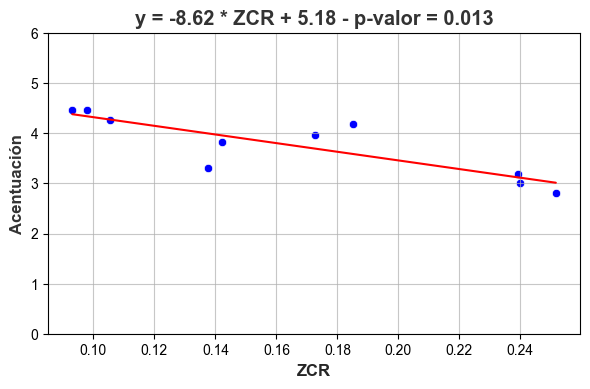

In [46]:
dims = (6 * len(dicc_model), 4)
fig, ax = plt.subplots(figsize=dims, ncols=len(dicc_model))

with sns.axes_style('darkgrid'):
    for i, (key, model) in enumerate(dicc_model.items()):
        if isinstance(ax, np.ndarray):
            ax_i = ax[i]
        else:
            ax_i = ax
        label = key.replace("_model", "")
        if label == 'f0':
            label = r'$f_{0}$'
        else:
            label = label.upper()
        g = sns.scatterplot(x=X[:, dicc_names_features[key]], y=y, ax=ax_i, color='blue')
        g = sns.lineplot(x=X[:, dicc_names_features[key]], y=dicc_pred[key], ax=ax_i, color='red')
        g.text(0.5, -0.1, label, weight='bold', size='large', family='Arial', stretch='extra-expanded', ha='center', va='top', transform=g.transAxes)
        g.set_ylabel('Acentuación', weight='bold', size='large', alpha=0.8, family='Arial', stretch='extra-expanded')
        g.set_title(list_equ[i], weight='bold', size='x-large', alpha=0.8, family='Arial', stretch='extra-expanded')
        g.grid(alpha=0.7)
        ax_i.set_ylim(0, 6)

    plt.tight_layout()
    plt.savefig(os.path.join(PATH, TEST_FOLDER, REGGRESSION_FOLDER, PARAMETRIC_FOLDER, ACENTUACION_FOLDER, MALE_FOLDER, 'regresiones_acentuacion_male.png'))
    plt.show()


In [47]:
if len(dicc_model) == 2:
    import plotly.express as px
    import plotly.graph_objects as go

    # Seleccionamos solo las características seleccionadas en X
    X_selected = X[:, selected_features]

    # Entrenamos el modelo de regresión con las características seleccionadas
    regr_multivar = LinearRegression()
    regr_multivar.fit(X_selected, y)

    # Obtenemos las predicciones del modelo para las características seleccionadas
    y_pred = regr_multivar.predict(X_selected)

    # Crear la figura
    fig = px.scatter_3d(x=X_selected[:, 0], y=X_selected[:, 1], z=y)

    # Crear el plano de regresión
    xx, yy = np.meshgrid(X_selected[:, 0], X_selected[:, 1])
    zz = regr_multivar.intercept_ + np.dot(np.array([xx.ravel(), yy.ravel()]).T, regr_multivar.coef_.ravel()).reshape(xx.shape)
    fig.add_trace(go.Surface(x=xx, y=yy, z=zz, opacity=0.5))

    # Construir la cadena de texto para la ecuación del plano
    equation = f'z = {regr_multivar.intercept_.round(2)}'
    for i, (key, model) in enumerate(dicc_model.items()):
        equation += f' + {regr_multivar.coef_[i].round(2)} * {key.replace("_model", "")}'
    
    # Centrar el título
    fig.update_layout(title=dict(text=equation, x=0.5, xanchor='center'))

    # Etiquetas de los ejes y rango del eje z
    fig.update_layout(scene=dict(xaxis_title=list(dicc_model.keys())[0].replace("_model", ""), yaxis_title=list(dicc_model.keys())[1].replace("_model", ""), zaxis_title='Acentuación', zaxis=dict(range=[0, 6])))

    fig.write_html(
       os.path.join(PATH, TEST_FOLDER, REGGRESSION_FOLDER, PARAMETRIC_FOLDER, ACENTUACION_FOLDER, MALE_FOLDER, 'regresion_acentuacion_multivariable_male.html')
    )

    fig.show()


#### Femenino

In [48]:
# Lista de p-values
p_values = []

mask_gender = df_acentuacion.genero == 'femenino'

df_acentuacion_female = df_acentuacion[mask_gender].drop(columns=['genero'])

In [49]:
# Cargamos los datos
X = np.array(df_acentuacion_female.drop(columns=['Acentuacion'])) # df_objetivos es el DataFrame con los parámetros objetivos
y = np.array(df_acentuacion_female.Acentuacion) # df_subjetivos es el DataFrame con los parámetros subjetivos

# Creamos el modelo de regresión lineal
regr_multivar = LinearRegression()

# Creamos el selector de características hacia adelante
forward_selector = SequentialFeatureSelector(regr_multivar, k_features='best', forward=True, scoring='neg_mean_squared_error')

# Entrenamos el selector de características
forward_selector.fit(X, y)

# Obtenemos las características seleccionadas
selected_features = forward_selector.k_feature_idx_

# Imprimimos las características seleccionadas
print('Características seleccionadas:', selected_features)

# Agregamos una columna de unos para representar el término de intercepción
X2 = sm.add_constant(X)

# Creamos el modelo OLS (mínimos cuadrados ordinarios) y lo ajustamos a los datos
model = sm.OLS(y, X2)
results = model.fit()

# Imprimimos los p-valores para cada característica seleccionada
for feature, pvalue in zip(list(range(X.shape[1])), results.pvalues[1:]):

    if feature == 0:
        feature = 'ZCR'
    elif feature == 1:
        feature = 'RMS'
    else:
        feature = 'f0'
    
    print(f'Característica {feature}: p-valor = {pvalue:.4f}')

    p_values.append(pvalue)
    dicc_p_value[feature].append(pvalue)

dicc_p_value['subjetive_parameter'].append('Acentuación')
dicc_p_value['genero'].append('femenino')


Características seleccionadas: (1, 2)
Característica ZCR: p-valor = 0.4388
Característica RMS: p-valor = 0.3738
Característica f0: p-valor = 0.0742


In [50]:
# Dicc auxiliar con los nombres asociadas a las variables
dicc_names_features = {
    'zcr_model': 0,
    'rms_model': 1,
    'f0_model': 2
}

# Dicc de los modelos
dicc_model = {}

# Dicc de las predicciones
dicc_pred = {}

for selected_feature in selected_features:
    # Entrenamos el modelo de regresión con las características seleccionadas
    regr_multivar = LinearRegression()
    regr_multivar.fit(X[:, selected_feature].reshape(-1, 1), y.ravel())

    # Almacenamos en dicc_model la clave asociada al modelo que se entrenó y el objeto modelo
    for key, value in dicc_names_features.items():
        if value == selected_feature:
            dicc_model[key] = regr_multivar

    # Obtenemos las predicciones del modelo para las características seleccionadas
    y_pred = regr_multivar.predict(X[:, selected_feature].reshape(-1, 1))

    # Almacenamos en dicc_pred la clave asociada al modelo que se entrenó y la predicción
    for key, value in dicc_names_features.items():
        if value == selected_feature:
            dicc_pred[key] = y_pred


In [51]:
list_equ = []

for key, model in dicc_model.items():
    # Obtenemos los valores de w y b
    w = model.coef_[0]
    b = model.intercept_
    
    label = key.replace("_model", "")
    if label == 'f0':
        label = r'$f_{0}$'
    else:
        label = label.upper()

    # Construimos la cadena de texto para la ecuación del hiperplano y su p-valor
    equation = f'y = {w:.2f} * {label} + {b:.2f} - p-valor = {p_values[dicc_names_features[key]]:.3f}'

    # Agregamos la cadena a la lista
    list_equ.append(equation)

# Mostramos el resultado
for equ in list_equ:
    print(equ)


y = 0.18 * RMS + 9.14 - p-valor = 0.374
y = -0.03 * $f_{0}$ + 6.82 - p-valor = 0.074


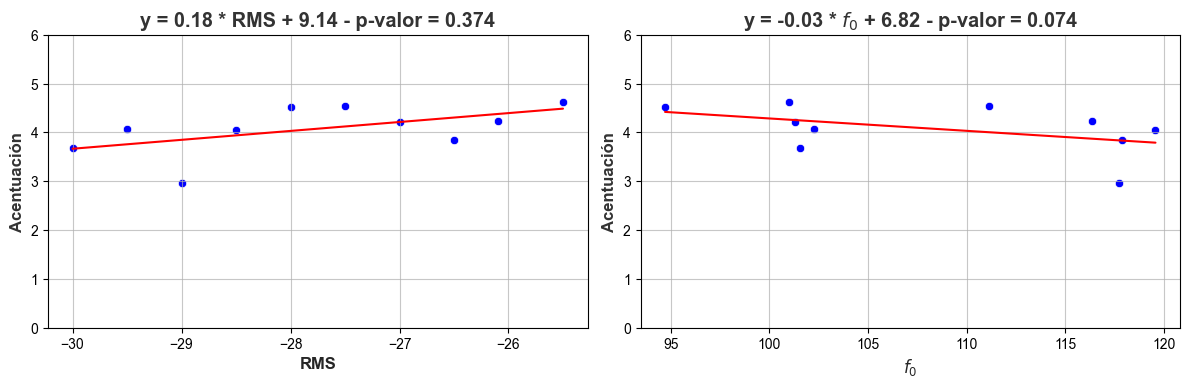

In [52]:
dims = (6 * len(dicc_model), 4)
fig, ax = plt.subplots(figsize=dims, ncols=len(dicc_model))

with sns.axes_style('darkgrid'):
    for i, (key, model) in enumerate(dicc_model.items()):
        if isinstance(ax, np.ndarray):
            ax_i = ax[i]
        else:
            ax_i = ax
        label = key.replace("_model", "")
        if label == 'f0':
            label = r'$f_{0}$'
        else:
            label = label.upper()
        g = sns.scatterplot(x=X[:, dicc_names_features[key]], y=y, ax=ax_i, color='blue')
        g = sns.lineplot(x=X[:, dicc_names_features[key]], y=dicc_pred[key], ax=ax_i, color='red')
        g.text(0.5, -0.1, label, weight='bold', size='large', family='Arial', stretch='extra-expanded', ha='center', va='top', transform=g.transAxes)
        g.set_ylabel('Acentuación', weight='bold', size='large', alpha=0.8, family='Arial', stretch='extra-expanded')
        g.set_title(list_equ[i], weight='bold', size='x-large', alpha=0.8, family='Arial', stretch='extra-expanded')
        g.grid(alpha=0.7)
        ax_i.set_ylim(0, 6)

    plt.tight_layout()
    plt.savefig(os.path.join(PATH, TEST_FOLDER, REGGRESSION_FOLDER, PARAMETRIC_FOLDER, ACENTUACION_FOLDER, FEMALE_FOLDER, 'regresiones_acentuacion_female.png'))
    plt.show()


In [53]:
if len(dicc_model) == 2:
    import plotly.express as px
    import plotly.graph_objects as go

    # Seleccionamos solo las características seleccionadas en X
    X_selected = X[:, selected_features]

    # Entrenamos el modelo de regresión con las características seleccionadas
    regr_multivar = LinearRegression()
    regr_multivar.fit(X_selected, y)

    # Obtenemos las predicciones del modelo para las características seleccionadas
    y_pred = regr_multivar.predict(X_selected)

    # Crear la figura
    fig = px.scatter_3d(x=X_selected[:, 0], y=X_selected[:, 1], z=y)

    # Crear el plano de regresión
    xx, yy = np.meshgrid(X_selected[:, 0], X_selected[:, 1])
    zz = regr_multivar.intercept_ + np.dot(np.array([xx.ravel(), yy.ravel()]).T, regr_multivar.coef_.ravel()).reshape(xx.shape)
    fig.add_trace(go.Surface(x=xx, y=yy, z=zz, opacity=0.5))

    # Construir la cadena de texto para la ecuación del plano
    equation = f'z = {regr_multivar.intercept_.round(2)}'
    for i, (key, model) in enumerate(dicc_model.items()):
        equation += f' + {regr_multivar.coef_[i].round(2)} * {key.replace("_model", "")}'
    
    # Centrar el título
    fig.update_layout(title=dict(text=equation, x=0.5, xanchor='center'))

    # Etiquetas de los ejes y rango del eje z
    fig.update_layout(scene=dict(xaxis_title=list(dicc_model.keys())[0].replace("_model", ""), yaxis_title=list(dicc_model.keys())[1].replace("_model", ""), zaxis_title='Acentuación', zaxis=dict(range=[0, 6]), yaxis=dict(tickvals=[100, 105, 110, 115])))

    fig.write_html(
       os.path.join(PATH, TEST_FOLDER, REGGRESSION_FOLDER, PARAMETRIC_FOLDER, ACENTUACION_FOLDER, FEMALE_FOLDER, 'regresion_acentuacion_multivariable_female.html')
    )

    fig.show()


### Naturalidad

In [54]:
df_naturalidad = df_union.loc[:, ['Naturalidad', 'zcr', 'rms', 'f0', 'genero']]

#### Masculino

In [55]:
# Lista de p-values
p_values = []

mask_gender = df_naturalidad.genero == 'masculino'

df_naturalidad_male = df_naturalidad[mask_gender].drop(columns=['genero'])

In [56]:
# Cargamos los datos
X = np.array(df_naturalidad_male.drop(columns=['Naturalidad'])) # df_objetivos es el DataFrame con los parámetros objetivos
y = np.array(df_naturalidad_male.Naturalidad) # df_subjetivos es el DataFrame con los parámetros subjetivos

# Creamos el modelo de regresión lineal
regr_multivar = LinearRegression()

# Creamos el selector de características hacia adelante
forward_selector = SequentialFeatureSelector(regr_multivar, k_features='best', forward=True, scoring='neg_mean_squared_error')

# Entrenamos el selector de características
forward_selector.fit(X, y)

# Obtenemos las características seleccionadas
selected_features = forward_selector.k_feature_idx_

# Imprimimos las características seleccionadas
print('Características seleccionadas:', selected_features)

# Agregamos una columna de unos para representar el término de intercepción
X2 = sm.add_constant(X)

# Creamos el modelo OLS (mínimos cuadrados ordinarios) y lo ajustamos a los datos
model = sm.OLS(y, X2)
results = model.fit()

# Imprimimos los p-valores para cada característica seleccionada
for feature, pvalue in zip(list(range(X.shape[1])), results.pvalues[1:]):

    if feature == 0:
        feature = 'ZCR'
    elif feature == 1:
        feature = 'RMS'
    else:
        feature = 'f0'
    
    print(f'Característica {feature}: p-valor = {pvalue:.4f}')

    p_values.append(pvalue)
    dicc_p_value[feature].append(pvalue)

dicc_p_value['subjetive_parameter'].append('Naturalidad')
dicc_p_value['genero'].append('masculino')


Características seleccionadas: (0,)
Característica ZCR: p-valor = 0.0276
Característica RMS: p-valor = 0.6642
Característica f0: p-valor = 0.5109


In [57]:
# Dicc auxiliar con los nombres asociadas a las variables
dicc_names_features = {
    'zcr_model': 0,
    'rms_model': 1,
    'f0_model': 2
}

# Dicc de los modelos
dicc_model = {}

# Dicc de las predicciones
dicc_pred = {}

for selected_feature in selected_features:
    # Entrenamos el modelo de regresión con las características seleccionadas
    regr_multivar = LinearRegression()
    regr_multivar.fit(X[:, selected_feature].reshape(-1, 1), y.ravel())

    # Almacenamos en dicc_model la clave asociada al modelo que se entrenó y el objeto modelo
    for key, value in dicc_names_features.items():
        if value == selected_feature:
            dicc_model[key] = regr_multivar

    # Obtenemos las predicciones del modelo para las características seleccionadas
    y_pred = regr_multivar.predict(X[:, selected_feature].reshape(-1, 1))

    # Almacenamos en dicc_pred la clave asociada al modelo que se entrenó y la predicción
    for key, value in dicc_names_features.items():
        if value == selected_feature:
            dicc_pred[key] = y_pred


In [58]:
list_equ = []

for key, model in dicc_model.items():
    # Obtenemos los valores de w y b
    w = model.coef_[0]
    b = model.intercept_
    
    label = key.replace("_model", "")
    if label == 'f0':
        label = r'$f_{0}$'
    else:
        label = label.upper()

    # Construimos la cadena de texto para la ecuación del hiperplano y su p-valor
    equation = f'y = {w:.2f} * {label} + {b:.2f} - p-valor = {p_values[dicc_names_features[key]]:.3f}'

    # Agregamos la cadena a la lista
    list_equ.append(equation)

# Mostramos el resultado
for equ in list_equ:
    print(equ)


y = -11.55 * ZCR + 4.63 - p-valor = 0.028


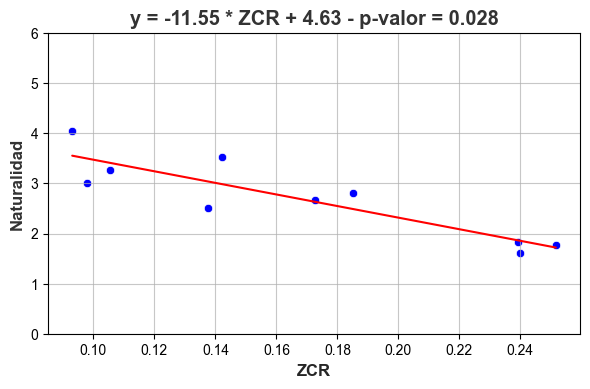

In [59]:
dims = (6 * len(dicc_model), 4)
fig, ax = plt.subplots(figsize=dims, ncols=len(dicc_model))

with sns.axes_style('darkgrid'):
    for i, (key, model) in enumerate(dicc_model.items()):
        if isinstance(ax, np.ndarray):
            ax_i = ax[i]
        else:
            ax_i = ax
        label = key.replace("_model", "")
        if label == 'f0':
            label = r'$f_{0}$'
        else:
            label = label.upper()
        g = sns.scatterplot(x=X[:, dicc_names_features[key]], y=y, ax=ax_i, color='blue')
        g = sns.lineplot(x=X[:, dicc_names_features[key]], y=dicc_pred[key], ax=ax_i, color='red')
        g.text(0.5, -0.1, label, weight='bold', size='large', family='Arial', stretch='extra-expanded', ha='center', va='top', transform=g.transAxes)
        g.set_ylabel('Naturalidad', weight='bold', size='large', alpha=0.8, family='Arial', stretch='extra-expanded')
        g.set_title(list_equ[i], weight='bold', size='x-large', alpha=0.8, family='Arial', stretch='extra-expanded')
        g.grid(alpha=0.7)
        ax_i.set_ylim(0, 6)

    plt.tight_layout()
    plt.savefig(os.path.join(PATH, TEST_FOLDER, REGGRESSION_FOLDER, PARAMETRIC_FOLDER, NATURALIDAD_FOLDER, MALE_FOLDER, 'regresiones_naturalidad_male.png'))
    plt.show()


In [60]:
if len(dicc_model) == 2:
    import plotly.express as px
    import plotly.graph_objects as go

    # Seleccionamos solo las características seleccionadas en X
    X_selected = X[:, selected_features]

    # Entrenamos el modelo de regresión con las características seleccionadas
    regr_multivar = LinearRegression()
    regr_multivar.fit(X_selected, y)

    # Obtenemos las predicciones del modelo para las características seleccionadas
    y_pred = regr_multivar.predict(X_selected)

    # Crear la figura
    fig = px.scatter_3d(x=X_selected[:, 0], y=X_selected[:, 1], z=y)

    # Crear el plano de regresión
    xx, yy = np.meshgrid(X_selected[:, 0], X_selected[:, 1])
    zz = regr_multivar.intercept_ + np.dot(np.array([xx.ravel(), yy.ravel()]).T, regr_multivar.coef_.ravel()).reshape(xx.shape)
    fig.add_trace(go.Surface(x=xx, y=yy, z=zz, opacity=0.5))

    # Construir la cadena de texto para la ecuación del plano
    equation = f'z = {regr_multivar.intercept_.round(2)}'
    for i, (key, model) in enumerate(dicc_model.items()):
        equation += f' + {regr_multivar.coef_[i].round(2)} * {key.replace("_model", "")}'
    
    # Centrar el título
    fig.update_layout(title=dict(text=equation, x=0.5, xanchor='center'))

    # Etiquetas de los ejes y rango del eje z
    fig.update_layout(scene=dict(xaxis_title=list(dicc_model.keys())[0].replace("_model", ""), yaxis_title=list(dicc_model.keys())[1].replace("_model", ""), zaxis_title='Naturalidad', zaxis=dict(range=[0, 6]), yaxis=dict(tickvals=[-24, -23, -22, -21])))

    fig.write_html(
       os.path.join(PATH, TEST_FOLDER, REGGRESSION_FOLDER, PARAMETRIC_FOLDER, NATURALIDAD_FOLDER, MALE_FOLDER, 'regresion_naturalidad_multivariable_male.html')
    )

    fig.show()


#### Femenino

In [61]:
# Lista de p-values
p_values = []

mask_gender = df_naturalidad.genero == 'femenino'

df_naturalidad_female = df_naturalidad[mask_gender].drop(columns=['genero'])

In [62]:
# Cargamos los datos
X = np.array(df_naturalidad_female.drop(columns=['Naturalidad'])) # df_objetivos es el DataFrame con los parámetros objetivos
y = np.array(df_naturalidad_female.Naturalidad) # df_subjetivos es el DataFrame con los parámetros subjetivos

# Creamos el modelo de regresión lineal
regr_multivar = LinearRegression()

# Creamos el selector de características hacia adelante
forward_selector = SequentialFeatureSelector(regr_multivar, k_features='best', forward=True, scoring='neg_mean_squared_error')

# Entrenamos el selector de características
forward_selector.fit(X, y)

# Obtenemos las características seleccionadas
selected_features = forward_selector.k_feature_idx_

# Imprimimos las características seleccionadas
print('Características seleccionadas:', selected_features)

# Agregamos una columna de unos para representar el término de intercepción
X2 = sm.add_constant(X)

# Creamos el modelo OLS (mínimos cuadrados ordinarios) y lo ajustamos a los datos
model = sm.OLS(y, X2)
results = model.fit()

# Imprimimos los p-valores para cada característica seleccionada
for feature, pvalue in zip(list(range(X.shape[1])), results.pvalues[1:]):

    if feature == 0:
        feature = 'ZCR'
    elif feature == 1:
        feature = 'RMS'
    else:
        feature = 'f0'
    
    print(f'Característica {feature}: p-valor = {pvalue:.4f}')

    p_values.append(pvalue)
    dicc_p_value[feature].append(pvalue)

dicc_p_value['subjetive_parameter'].append('Naturalidad')
dicc_p_value['genero'].append('femenino')


Características seleccionadas: (1, 2)
Característica ZCR: p-valor = 0.0969
Característica RMS: p-valor = 0.3137
Característica f0: p-valor = 0.0506


In [63]:
# Dicc auxiliar con los nombres asociadas a las variables
dicc_names_features = {
    'zcr_model': 0,
    'rms_model': 1,
    'f0_model': 2
}

# Dicc de los modelos
dicc_model = {}

# Dicc de las predicciones
dicc_pred = {}

for selected_feature in selected_features:
    # Entrenamos el modelo de regresión con las características seleccionadas
    regr_multivar = LinearRegression()
    regr_multivar.fit(X[:, selected_feature].reshape(-1, 1), y.ravel())

    # Almacenamos en dicc_model la clave asociada al modelo que se entrenó y el objeto modelo
    for key, value in dicc_names_features.items():
        if value == selected_feature:
            dicc_model[key] = regr_multivar

    # Obtenemos las predicciones del modelo para las características seleccionadas
    y_pred = regr_multivar.predict(X[:, selected_feature].reshape(-1, 1))

    # Almacenamos en dicc_pred la clave asociada al modelo que se entrenó y la predicción
    for key, value in dicc_names_features.items():
        if value == selected_feature:
            dicc_pred[key] = y_pred


In [64]:
list_equ = []

for key, model in dicc_model.items():
    # Obtenemos los valores de w y b
    w = model.coef_[0]
    b = model.intercept_
    
    label = key.replace("_model", "")
    if label == 'f0':
        label = r'$f_{0}$'
    else:
        label = label.upper()

    # Construimos la cadena de texto para la ecuación del hiperplano y su p-valor
    equation = f'y = {w:.2f} * {label} + {b:.2f} - p-valor = {p_values[dicc_names_features[key]]:.3f}'

    # Agregamos la cadena a la lista
    list_equ.append(equation)

# Mostramos el resultado
for equ in list_equ:
    print(equ)


y = 0.36 * RMS + 13.09 - p-valor = 0.314
y = -0.03 * $f_{0}$ + 6.27 - p-valor = 0.051


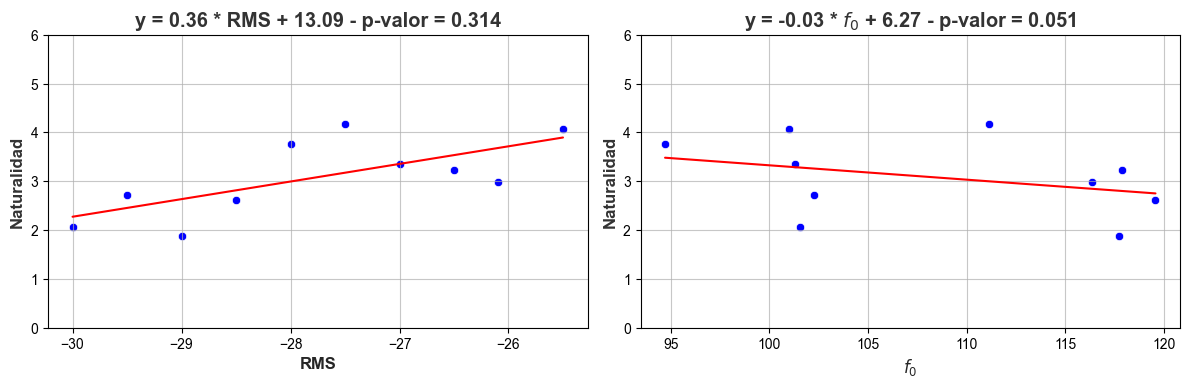

In [65]:
dims = (6 * len(dicc_model), 4)
fig, ax = plt.subplots(figsize=dims, ncols=len(dicc_model))

with sns.axes_style('darkgrid'):
    for i, (key, model) in enumerate(dicc_model.items()):
        if isinstance(ax, np.ndarray):
            ax_i = ax[i]
        else:
            ax_i = ax
        label = key.replace("_model", "")
        if label == 'f0':
            label = r'$f_{0}$'
        else:
            label = label.upper()
        g = sns.scatterplot(x=X[:, dicc_names_features[key]], y=y, ax=ax_i, color='blue')
        g = sns.lineplot(x=X[:, dicc_names_features[key]], y=dicc_pred[key], ax=ax_i, color='red')
        g.text(0.5, -0.1, label, weight='bold', size='large', family='Arial', stretch='extra-expanded', ha='center', va='top', transform=g.transAxes)
        g.set_ylabel('Naturalidad', weight='bold', size='large', alpha=0.8, family='Arial', stretch='extra-expanded')
        g.set_title(list_equ[i], weight='bold', size='x-large', alpha=0.8, family='Arial', stretch='extra-expanded')
        g.grid(alpha=0.7)
        ax_i.set_ylim(0, 6)

    plt.tight_layout()
    plt.savefig(os.path.join(PATH, TEST_FOLDER, REGGRESSION_FOLDER, PARAMETRIC_FOLDER, NATURALIDAD_FOLDER, FEMALE_FOLDER, 'regresiones_naturalidad_female.png'))
    plt.show()


In [66]:
if len(dicc_model) == 2:
    import plotly.express as px
    import plotly.graph_objects as go

    # Seleccionamos solo las características seleccionadas en X
    X_selected = X[:, selected_features]

    # Entrenamos el modelo de regresión con las características seleccionadas
    regr_multivar = LinearRegression()
    regr_multivar.fit(X_selected, y)

    # Obtenemos las predicciones del modelo para las características seleccionadas
    y_pred = regr_multivar.predict(X_selected)

    # Crear la figura
    fig = px.scatter_3d(x=X_selected[:, 0], y=X_selected[:, 1], z=y)

    # Crear el plano de regresión
    xx, yy = np.meshgrid(X_selected[:, 0], X_selected[:, 1])
    zz = regr_multivar.intercept_ + np.dot(np.array([xx.ravel(), yy.ravel()]).T, regr_multivar.coef_.ravel()).reshape(xx.shape)
    fig.add_trace(go.Surface(x=xx, y=yy, z=zz, opacity=0.5))

    # Construir la cadena de texto para la ecuación del plano
    equation = f'z = {regr_multivar.intercept_.round(2)}'
    for i, (key, model) in enumerate(dicc_model.items()):
        equation += f' + {regr_multivar.coef_[i].round(2)} * {key.replace("_model", "")}'
    
    # Centrar el título
    fig.update_layout(title=dict(text=equation, x=0.5, xanchor='center'))

    # Etiquetas de los ejes y rango del eje z
    fig.update_layout(scene=dict(xaxis_title=list(dicc_model.keys())[0].replace("_model", ""), yaxis_title=list(dicc_model.keys())[1].replace("_model", ""), zaxis_title='Naturalidad', zaxis=dict(range=[0, 6]), yaxis=dict(tickvals=[100, 105, 110, 115])))

    fig.write_html(
       os.path.join(PATH, TEST_FOLDER, REGGRESSION_FOLDER, PARAMETRIC_FOLDER, NATURALIDAD_FOLDER, FEMALE_FOLDER, 'regresion_naturalidad_multivariable_female.html')
    )

    fig.show()


### Cadencia

In [67]:
df_cadencia = df_union.loc[:, ['Cadencia', 'zcr', 'rms', 'f0', 'genero']]

#### Masculino

In [68]:
# Lista de p-values
p_values = []

mask_gender = df_cadencia.genero == 'masculino'

df_cadencia_male = df_cadencia[mask_gender].drop(columns=['genero'])

In [69]:
# Cargamos los datos
X = np.array(df_cadencia_male.drop(columns=['Cadencia'])) # df_objetivos es el DataFrame con los parámetros objetivos
y = np.array(df_cadencia_male.Cadencia) # df_subjetivos es el DataFrame con los parámetros subjetivos

# Creamos el modelo de regresión lineal
regr_multivar = LinearRegression()

# Creamos el selector de características hacia adelante
forward_selector = SequentialFeatureSelector(regr_multivar, k_features='best', forward=True, scoring='neg_mean_squared_error')

# Entrenamos el selector de características
forward_selector.fit(X, y)

# Obtenemos las características seleccionadas
selected_features = forward_selector.k_feature_idx_

# Imprimimos las características seleccionadas
print('Características seleccionadas:', selected_features)

# Agregamos una columna de unos para representar el término de intercepción
X2 = sm.add_constant(X)

# Creamos el modelo OLS (mínimos cuadrados ordinarios) y lo ajustamos a los datos
model = sm.OLS(y, X2)
results = model.fit()

# Imprimimos los p-valores para cada característica seleccionada
for feature, pvalue in zip(list(range(X.shape[1])), results.pvalues[1:]):

    if feature == 0:
        feature = 'ZCR'
    elif feature == 1:
        feature = 'RMS'
    else:
        feature = 'f0'
    
    print(f'Característica {feature}: p-valor = {pvalue:.4f}')

    p_values.append(pvalue)
    dicc_p_value[feature].append(pvalue)

dicc_p_value['subjetive_parameter'].append('Cadencia')
dicc_p_value['genero'].append('masculino')


Características seleccionadas: (0, 2)
Característica ZCR: p-valor = 0.0019
Característica RMS: p-valor = 0.3650
Característica f0: p-valor = 0.8906


In [70]:
# Dicc auxiliar con los nombres asociadas a las variables
dicc_names_features = {
    'zcr_model': 0,
    'rms_model': 1,
    'f0_model': 2
}

# Dicc de los modelos
dicc_model = {}

# Dicc de las predicciones
dicc_pred = {}

for selected_feature in selected_features:
    # Entrenamos el modelo de regresión con las características seleccionadas
    regr_multivar = LinearRegression()
    regr_multivar.fit(X[:, selected_feature].reshape(-1, 1), y.ravel())

    # Almacenamos en dicc_model la clave asociada al modelo que se entrenó y el objeto modelo
    for key, value in dicc_names_features.items():
        if value == selected_feature:
            dicc_model[key] = regr_multivar

    # Obtenemos las predicciones del modelo para las características seleccionadas
    y_pred = regr_multivar.predict(X[:, selected_feature].reshape(-1, 1))

    # Almacenamos en dicc_pred la clave asociada al modelo que se entrenó y la predicción
    for key, value in dicc_names_features.items():
        if value == selected_feature:
            dicc_pred[key] = y_pred


In [71]:
list_equ = []

for key, model in dicc_model.items():
    # Obtenemos los valores de w y b
    w = model.coef_[0]
    b = model.intercept_
    
    label = key.replace("_model", "")
    if label == 'f0':
        label = r'$f_{0}$'
    else:
        label = label.upper()

    # Construimos la cadena de texto para la ecuación del hiperplano y su p-valor
    equation = f'y = {w:.2f} * {label} + {b:.2f} - p-valor = {p_values[dicc_names_features[key]]:.3f}'

    # Agregamos la cadena a la lista
    list_equ.append(equation)

# Mostramos el resultado
for equ in list_equ:
    print(equ)


y = -14.92 * ZCR + 5.31 - p-valor = 0.002
y = -0.07 * $f_{0}$ + 8.31 - p-valor = 0.891


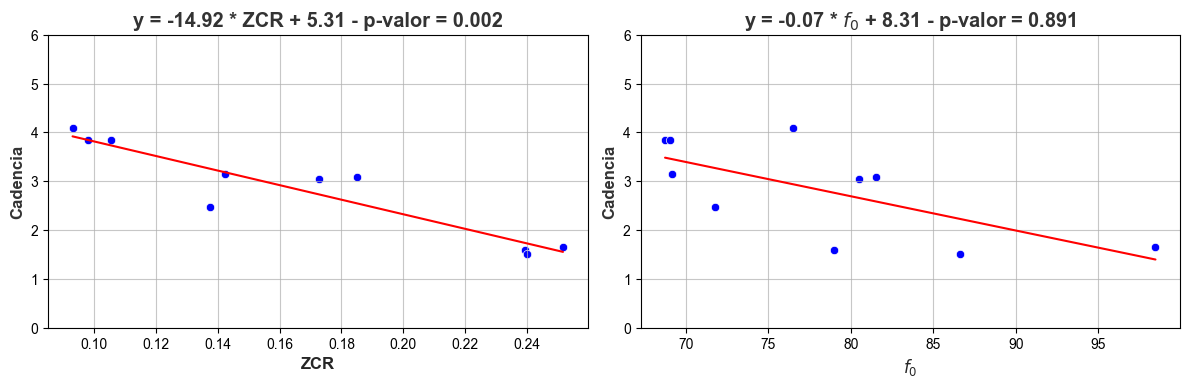

In [72]:
dims = (6 * len(dicc_model), 4)
fig, ax = plt.subplots(figsize=dims, ncols=len(dicc_model))

with sns.axes_style('darkgrid'):
    for i, (key, model) in enumerate(dicc_model.items()):
        if isinstance(ax, np.ndarray):
            ax_i = ax[i]
        else:
            ax_i = ax
        label = key.replace("_model", "")
        if label == 'f0':
            label = r'$f_{0}$'
        else:
            label = label.upper()
        g = sns.scatterplot(x=X[:, dicc_names_features[key]], y=y, ax=ax_i, color='blue')
        g = sns.lineplot(x=X[:, dicc_names_features[key]], y=dicc_pred[key], ax=ax_i, color='red')
        g.text(0.5, -0.1, label, weight='bold', size='large', family='Arial', stretch='extra-expanded', ha='center', va='top', transform=g.transAxes)
        g.set_ylabel('Cadencia', weight='bold', size='large', alpha=0.8, family='Arial', stretch='extra-expanded')
        g.set_title(list_equ[i], weight='bold', size='x-large', alpha=0.8, family='Arial', stretch='extra-expanded')
        g.grid(alpha=0.7)
        ax_i.set_ylim(0, 6)

    plt.tight_layout()
    plt.savefig(os.path.join(PATH, TEST_FOLDER, REGGRESSION_FOLDER, PARAMETRIC_FOLDER, CADENCIA_FOLDER, MALE_FOLDER, 'regresiones_cadencia_male.png'))
    plt.show()


In [73]:
if len(dicc_model) == 2:
    import plotly.express as px
    import plotly.graph_objects as go

    # Seleccionamos solo las características seleccionadas en X
    X_selected = X[:, selected_features]

    # Entrenamos el modelo de regresión con las características seleccionadas
    regr_multivar = LinearRegression()
    regr_multivar.fit(X_selected, y)

    # Obtenemos las predicciones del modelo para las características seleccionadas
    y_pred = regr_multivar.predict(X_selected)

    # Crear la figura
    fig = px.scatter_3d(x=X_selected[:, 0], y=X_selected[:, 1], z=y)

    # Crear el plano de regresión
    xx, yy = np.meshgrid(X_selected[:, 0], X_selected[:, 1])
    zz = regr_multivar.intercept_ + np.dot(np.array([xx.ravel(), yy.ravel()]).T, regr_multivar.coef_.ravel()).reshape(xx.shape)
    fig.add_trace(go.Surface(x=xx, y=yy, z=zz, opacity=0.5))

    # Construir la cadena de texto para la ecuación del plano
    equation = f'z = {regr_multivar.intercept_.round(2)}'
    for i, (key, model) in enumerate(dicc_model.items()):
        equation += f' + {regr_multivar.coef_[i].round(2)} * {key.replace("_model", "")}'
    
    # Centrar el título
    fig.update_layout(title=dict(text=equation, x=0.5, xanchor='center'))

    # Etiquetas de los ejes y rango del eje z
    fig.update_layout(scene=dict(xaxis_title=list(dicc_model.keys())[0].replace("_model", ""), yaxis_title=list(dicc_model.keys())[1].replace("_model", ""), zaxis_title='Cadencia', zaxis=dict(range=[0, 6]), yaxis=dict(tickvals=[75, 80, 85, 90, 95])))

    fig.write_html(
       os.path.join(PATH, TEST_FOLDER, REGGRESSION_FOLDER, PARAMETRIC_FOLDER, CADENCIA_FOLDER, MALE_FOLDER, 'regresion_cadencia_multivariable_male.html')
    )

    fig.show()


#### Femenino

In [74]:
# Lista de p-values
p_values = []

mask_gender = df_cadencia.genero == 'femenino'

df_cadencia_female = df_cadencia[mask_gender].drop(columns=['genero'])

In [75]:
# Cargamos los datos
X = np.array(df_cadencia_female.drop(columns=['Cadencia'])) # df_objetivos es el DataFrame con los parámetros objetivos
y = np.array(df_cadencia_female.Cadencia) # df_subjetivos es el DataFrame con los parámetros subjetivos

# Creamos el modelo de regresión lineal
regr_multivar = LinearRegression()

# Creamos el selector de características hacia adelante
forward_selector = SequentialFeatureSelector(regr_multivar, k_features='best', forward=True, scoring='neg_mean_squared_error')

# Entrenamos el selector de características
forward_selector.fit(X, y)

# Obtenemos las características seleccionadas
selected_features = forward_selector.k_feature_idx_

# Imprimimos las características seleccionadas
print('Características seleccionadas:', selected_features)

# Agregamos una columna de unos para representar el término de intercepción
X2 = sm.add_constant(X)

# Creamos el modelo OLS (mínimos cuadrados ordinarios) y lo ajustamos a los datos
model = sm.OLS(y, X2)
results = model.fit()

# Imprimimos los p-valores para cada característica seleccionada
for feature, pvalue in zip(list(range(X.shape[1])), results.pvalues[1:]):

    if feature == 0:
        feature = 'ZCR'
    elif feature == 1:
        feature = 'RMS'
    else:
        feature = 'f0'
    
    print(f'Característica {feature}: p-valor = {pvalue:.4f}')

    p_values.append(pvalue)
    dicc_p_value[feature].append(pvalue)

dicc_p_value['subjetive_parameter'].append('Cadencia')
dicc_p_value['genero'].append('femenino')


Características seleccionadas: (0, 1, 2)
Característica ZCR: p-valor = 0.0469
Característica RMS: p-valor = 0.0272
Característica f0: p-valor = 0.0141


In [76]:
# Dicc auxiliar con los nombres asociadas a las variables
dicc_names_features = {
    'zcr_model': 0,
    'rms_model': 1,
    'f0_model': 2
}

# Dicc de los modelos
dicc_model = {}

# Dicc de las predicciones
dicc_pred = {}

for selected_feature in selected_features:
    # Entrenamos el modelo de regresión con las características seleccionadas
    regr_multivar = LinearRegression()
    regr_multivar.fit(X[:, selected_feature].reshape(-1, 1), y.ravel())

    # Almacenamos en dicc_model la clave asociada al modelo que se entrenó y el objeto modelo
    for key, value in dicc_names_features.items():
        if value == selected_feature:
            dicc_model[key] = regr_multivar

    # Obtenemos las predicciones del modelo para las características seleccionadas
    y_pred = regr_multivar.predict(X[:, selected_feature].reshape(-1, 1))

    # Almacenamos en dicc_pred la clave asociada al modelo que se entrenó y la predicción
    for key, value in dicc_names_features.items():
        if value == selected_feature:
            dicc_pred[key] = y_pred


In [77]:
list_equ = []

for key, model in dicc_model.items():
    # Obtenemos los valores de w y b
    w = model.coef_[0]
    b = model.intercept_
    
    label = key.replace("_model", "")
    if label == 'f0':
        label = r'$f_{0}$'
    else:
        label = label.upper()

    # Construimos la cadena de texto para la ecuación del hiperplano y su p-valor
    equation = f'y = {w:.2f} * {label} + {b:.2f} - p-valor = {p_values[dicc_names_features[key]]:.3f}'

    # Agregamos la cadena a la lista
    list_equ.append(equation)

# Mostramos el resultado
for equ in list_equ:
    print(equ)


y = -12.43 * ZCR + 5.31 - p-valor = 0.047
y = 0.48 * RMS + 16.73 - p-valor = 0.027
y = -0.03 * $f_{0}$ + 6.30 - p-valor = 0.014


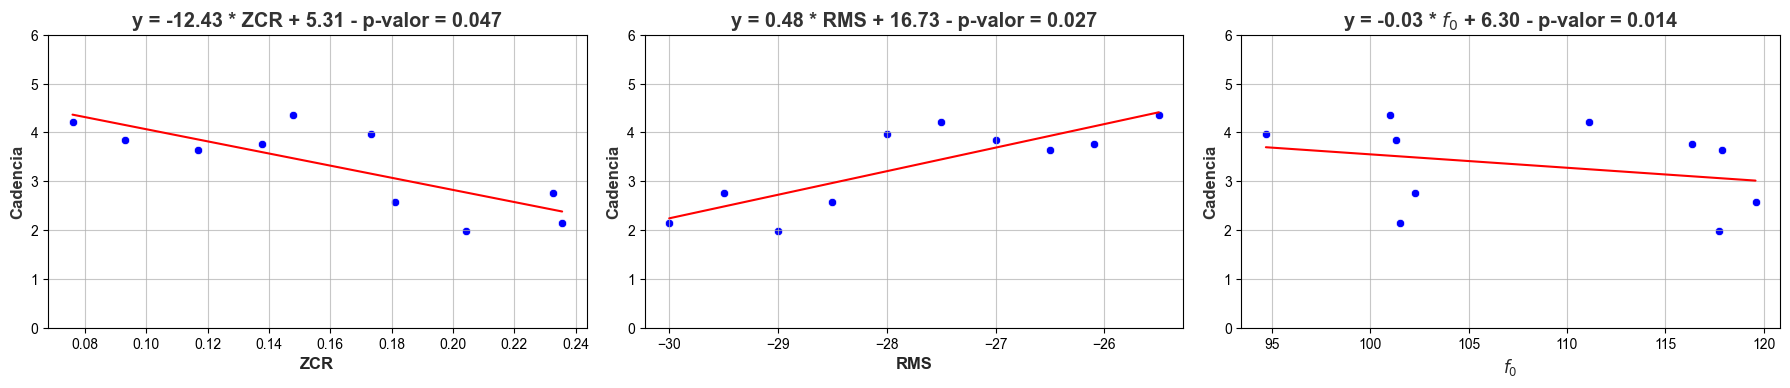

In [78]:
dims = (6 * len(dicc_model), 4)
fig, ax = plt.subplots(figsize=dims, ncols=len(dicc_model))

with sns.axes_style('darkgrid'):
    for i, (key, model) in enumerate(dicc_model.items()):
        if isinstance(ax, np.ndarray):
            ax_i = ax[i]
        else:
            ax_i = ax
        label = key.replace("_model", "")
        if label == 'f0':
            label = r'$f_{0}$'
        else:
            label = label.upper()
        g = sns.scatterplot(x=X[:, dicc_names_features[key]], y=y, ax=ax_i, color='blue')
        g = sns.lineplot(x=X[:, dicc_names_features[key]], y=dicc_pred[key], ax=ax_i, color='red')
        g.text(0.5, -0.1, label, weight='bold', size='large', family='Arial', stretch='extra-expanded', ha='center', va='top', transform=g.transAxes)
        g.set_ylabel('Cadencia', weight='bold', size='large', alpha=0.8, family='Arial', stretch='extra-expanded')
        g.set_title(list_equ[i], weight='bold', size='x-large', alpha=0.8, family='Arial', stretch='extra-expanded')
        g.grid(alpha=0.7)
        ax_i.set_ylim(0, 6)

    plt.tight_layout()
    plt.savefig(os.path.join(PATH, TEST_FOLDER, REGGRESSION_FOLDER, PARAMETRIC_FOLDER, CADENCIA_FOLDER, FEMALE_FOLDER, 'regresiones_cadencia_female.png'))
    plt.show()


In [79]:
if len(dicc_model) == 2:
    import plotly.express as px
    import plotly.graph_objects as go

    # Seleccionamos solo las características seleccionadas en X
    X_selected = X[:, selected_features]

    # Entrenamos el modelo de regresión con las características seleccionadas
    regr_multivar = LinearRegression()
    regr_multivar.fit(X_selected, y)

    # Obtenemos las predicciones del modelo para las características seleccionadas
    y_pred = regr_multivar.predict(X_selected)

    # Crear la figura
    fig = px.scatter_3d(x=X_selected[:, 0], y=X_selected[:, 1], z=y)

    # Crear el plano de regresión
    xx, yy = np.meshgrid(X_selected[:, 0], X_selected[:, 1])
    zz = regr_multivar.intercept_ + np.dot(np.array([xx.ravel(), yy.ravel()]).T, regr_multivar.coef_.ravel()).reshape(xx.shape)
    fig.add_trace(go.Surface(x=xx, y=yy, z=zz, opacity=0.5))

    # Construir la cadena de texto para la ecuación del plano
    equation = f'z = {regr_multivar.intercept_.round(2)}'
    for i, (key, model) in enumerate(dicc_model.items()):
        equation += f' + {regr_multivar.coef_[i].round(2)} * {key.replace("_model", "")}'
    
    # Centrar el título
    fig.update_layout(title=dict(text=equation, x=0.5, xanchor='center'))

    # Etiquetas de los ejes y rango del eje z
    fig.update_layout(scene=dict(xaxis_title=list(dicc_model.keys())[0].replace("_model", ""), yaxis_title=list(dicc_model.keys())[1].replace("_model", ""), zaxis_title='Cadencia', zaxis=dict(range=[0, 6]), yaxis=dict(tickvals=[100, 105, 110, 115, 120])))

    fig.write_html(
       os.path.join(PATH, TEST_FOLDER, REGGRESSION_FOLDER, PARAMETRIC_FOLDER, CADENCIA_FOLDER, FEMALE_FOLDER, 'regresion_cadencia_multivariable_female.html')
    )

    fig.show()

## Output p-values regressions

In [80]:
df_output_p_value_regression = pd.DataFrame(dicc_p_value)

In [81]:
df_output_p_value_regression

,subjetive_parameter,ZCR,RMS,f0,genero
0,Inteligibilidad,0.080721,0.272388,0.388501,masculino
1,Inteligibilidad,0.015486,0.842206,0.025511,femenino
2,Pronunciación,0.002727,0.015201,0.171269,masculino
3,Pronunciación,0.150439,0.689773,0.104651,femenino
4,Acentuación,0.013115,0.126748,0.367425,masculino
5,Acentuación,0.438756,0.373768,0.074234,femenino
6,Naturalidad,0.027625,0.664158,0.510930,masculino
7,Naturalidad,0.096910,0.313746,0.050623,femenino
8,Cadencia,0.001908,0.365016,0.890624,masculino
9,Cadencia,0.046939,0.027165,0.014133,femenino


In [82]:
df_output_p_value_regression.to_excel(
    os.path.join(PATH, TEST_FOLDER, REGGRESSION_FOLDER, 'output_p_values_parametric_regressions.xlsx'),
    index=False
)